<a href="https://colab.research.google.com/github/nithindsouza/CNN_from_scratch/blob/main/CNN_MSRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#required packages
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
from scipy import signal

In [2]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

In [3]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return np.dot(self.weights.T, output_gradient)

In [4]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [5]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [6]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [7]:
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

In [8]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [9]:
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

In [10]:
# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

11501568/11490434 [==============================] - 0s 0us/step


In [11]:
# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

In [12]:
epochs = 20
learning_rate = 0.1

In [13]:
# train
for e in range(epochs):
    error = 0
    for x, y in zip(x_train, y_train):
        # forward
        output = x
        for layer in network:
            output = layer.forward(output)

        # error
        error += binary_cross_entropy(y, output)

        # backward
        grad = binary_cross_entropy_prime(y, output)
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)

    error /= len(x_train)
    print(f"{e + 1}/{epochs}, error={error}")

1/20, error=0.585678715171567
2/20, error=0.12694391478889971
3/20, error=0.04611783223490648
4/20, error=0.03309759277607037
5/20, error=0.018905125360547205
6/20, error=0.010998649034354152
7/20, error=0.008666414135609047
8/20, error=0.0073379058088635695
9/20, error=0.006426624659741542
10/20, error=0.005702290730318146
11/20, error=0.0051428645535232485
12/20, error=0.0046954339790393415
13/20, error=0.004327568954104508
14/20, error=0.004018089228419378
15/20, error=0.003752821303137382
16/20, error=0.0035220088933799786
17/20, error=0.0033186940345477844
18/20, error=0.0031377500207065705
19/20, error=0.0029752951050372413
20/20, error=0.0028283128426082023


In [31]:
# test
pred = []
actual = []
for x, y in zip(x_test, y_test):
    output = x
    for layer in network:
      output = layer.forward(output)
    pred.append(np.argmax(output))
    actual.append(np.argmax(y))
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true:

In [33]:
# confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(actual,pred, labels=[1,0])
print('Confusion matrix : \n',matrix)


Confusion matrix : 
 [[100   0]
 [  0 100]]


In [34]:
# classification report for precision, recall f1-score and accuracy
from sklearn.metrics import classification_report
matrix = classification_report(actual,pred,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       100
           0       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



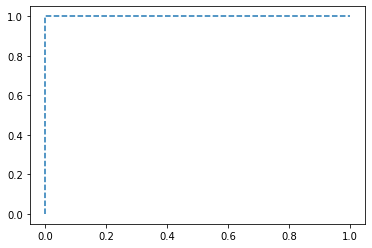

In [36]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr, tpr, _ = roc_curve(actual, pred)
# plot the roc curve for the model
pyplot.plot(fpr, tpr, linestyle='--', label='CNN')